# Introducing space occupation 

We focus on the space occupation of basketball players. We'd like to know how we can quantify the occupation and how we can visualize this occupation of the court.

## Voronoi cutting
----

First, we can use Voronoi diagram to partitionate the court into cells which belong to a unique player.

### Voronoi diagram

The first thing we have to do is to extract the data from json files. The function *json_extracter* is available in the python file *data_extracter* in the folder python_file.

In [1]:
from python_files.data_extracter import json_extracter
import numpy as np
import matplotlib.pyplot as plt
import math as m

data,events=json_extracter('data/game1.json')

We compute a function that plot voroni diagram of a moment of a play

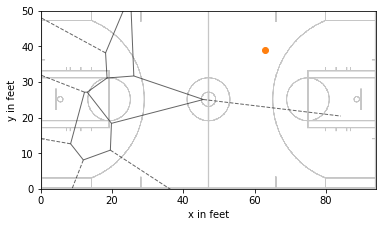

In [5]:
from scipy.spatial import Voronoi, voronoi_plot_2d
    
def voronoi(events,event_id,mom_id): 
    event=events[event_id]
    moment=event['moments'][mom_id][5] # we only take the five index of moment info because it contains players' and ball's position
    points = np.array([[player[2],player[3]] for player in moment[1:]])
    vor = Voronoi(points)
    fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='black',line_width=1, line_alpha=0.6, point_size=0)
    plt.xlim(0,94) #force the plt.show to adapt the size
    plt.ylim(0,50)
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')

voronoi(events,0,25)
field = plt.imread("Images/fullcourt.png")
plt.imshow(field, extent=[0,94,0,50])
plt.plot(63,39,'o')
plt.show()

Now, we want to add ball's position, player's velocity vector and to distinguish defenders and attackers

In [3]:
def players_ball_speed_position(moment1,moment2):
    
    dt=moment1[2]-moment2[2]
    mom_infos={}
    mom_infos['ball']={}
    mom_infos['team1']={}
    mom_infos['team2']={}
    for i in range(11) :
        if i==0:
            mom_infos['ball']['xy']=np.array(moment1[5][i][2:4])
            mom_infos['ball']['z']=moment1[5][i][4]
            mom_infos['ball']['v']=np.array([(moment2[5][i][2]-moment1[5][i][2])/dt,(moment2[5][i][3]-moment1[5][i][3])/dt])
        if 6<=i<=11:
            mom_infos['team2'][str(moment1[5][i][1])]={'xy':np.array(moment1[5][i][2:4]),'v':np.array([(moment2[5][i][2]-moment1[5][i][2])/dt,(moment2[5][i][3]-moment1[5][i][3])/dt])}
        if 1<=i<=5:
            mom_infos['team1'][str(moment1[5][i][1])]={'xy':np.array(moment1[5][i][2:4]),'v':np.array([(moment2[5][i][2]-moment1[5][i][2])/dt,(moment2[5][i][3]-moment1[5][i][3])/dt])}
    return(mom_infos)

In [4]:
def print_court_teams_occupation(events,event_id,mom_id,voronoi_cut=False,player_info=False):
    "This function return a visualization of the court for the moment mom_id of the event event_id. If voronoi=True, voronoi cutting is plotted."
    if voronoi_cut:
        voronoi(events,event_id,mom_id)
    event=events[event_id]
    moment=event['moments'][mom_id]
    moment1=moment
    moment2=event['moments'][mom_id+1]
    
    # separation of ball, team1 and team2 and calculation of the speed
    mom_infos=players_ball_speed_position(moment1,moment2)
    
    p=1
    for player in mom_infos['team2'].keys():
        x=mom_infos['team2'][player]['xy'][0]
        y=mom_infos['team2'][player]['xy'][1]
        vx=mom_infos['team2'][player]['v'][0]
        vy=mom_infos['team2'][player]['v'][1]
        plt.plot(x,y,'bo',markersize=12,alpha=0.6)
        plt.arrow(x,y,vx,vy,shape='full',lw=1.5,head_width=1)
        if player_info:
            plt.annotate(str(p),(x,y),xytext=(3,3),textcoords='offset points')
            p+=1
    
    for player in mom_infos['team1'].keys():
        x=mom_infos['team1'][player]['xy'][0]
        y=mom_infos['team1'][player]['xy'][1]
        vx=mom_infos['team1'][player]['v'][0]
        vy=mom_infos['team1'][player]['v'][1]
        plt.plot(x,y,'ro',markersize=12,alpha=0.6)
        plt.arrow(x,y,vx,vy,shape='full',lw=1.5,head_width=1)
        if player_info:
            plt.annotate(str(p),(x,y),xytext=(3,3),textcoords='offset points')
            p+=1
    
    plt.plot(mom_infos['ball']['xy'][0],mom_infos['ball']['xy'][1],'yo')
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')

    field = plt.imread("Images/fullcourt.png")
    plt.imshow(field, extent=[0,94,0,50])
    plt.show()

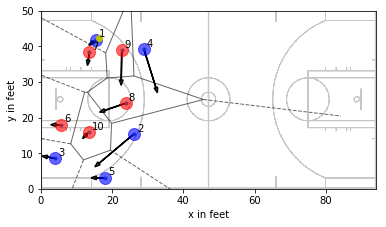

In [5]:
print_court_teams_occupation(events,0,25,voronoi_cut=True,player_info=True)

### Add a valuation to voronoi diagram

The aim is to add visual tool to highlight the fact a player doesn't occupy his cell uniformly : the closest of a point he is, the more he control the space. To do so, we cut the court into cells and we attribute a value to each cell by introducing a continuous measure, taking into account the relative distance of a point to a player. This quantity, $\delta_d$ is calculated as the difference between the distance $d$ from the point $(x,y)$ to the closest player and the distance from the same point to the closest opponent,
\begin{equation}\label{eq:deltad}
    \delta_d(x,y)=d_\textrm{closest player}-d_\textrm{closest opponent}.
\end{equation}

In [6]:
def distance(a,b):      #a = (x,y) departure point ; b = (i,j) arrival point
    return m.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [7]:
def print_court_teams_occupation(events,event_id,mom_id,voronoi_cut=False,value=False,player_info=False,n=50,p=94):
    "This function return a visualization of the court for the moment mom_id of the event event_id. If voronoi_cut=True, voronoi cutting is plotted. Then, if value=True, a heat-map giving a value to space occupation is drawn."
    if voronoi_cut:
        voronoi(events,event_id,mom_id)
    event=events[event_id]
    moment=event['moments'][mom_id]
    moment1=moment
    moment2=event['moments'][mom_id+1]
    
    # separation of ball, team1 and team2 and calculation of the speed
    mom_infos=players_ball_speed_position(moment1,moment2)
    
    ind=1
    for player in mom_infos['team2'].keys():
        x=mom_infos['team2'][player]['xy'][0]
        y=mom_infos['team2'][player]['xy'][1]
        vx=mom_infos['team2'][player]['v'][0]
        vy=mom_infos['team2'][player]['v'][1]
        plt.plot(x,y,'bo',markersize=12,alpha=0.6)
        plt.arrow(x,y,vx,vy,shape='full',lw=1.5,head_width=1)
        if player_info:
            plt.annotate(str(ind),(x,y),xytext=(3,3),textcoords='offset points')
            ind+=1
    
    for player in mom_infos['team1'].keys():
        x=mom_infos['team1'][player]['xy'][0]
        y=mom_infos['team1'][player]['xy'][1]
        vx=mom_infos['team1'][player]['v'][0]
        vy=mom_infos['team1'][player]['v'][1]
        plt.plot(x,y,'ro',markersize=12,alpha=0.6)
        plt.arrow(x,y,vx,vy,shape='full',lw=1.5,head_width=1)
        if player_info:
            plt.annotate(str(ind),(x,y),xytext=(3,3),textcoords='offset points')
            ind+=1
    if value:
        court=np.zeros((n,p))
        for i in range(n):
            for j in range(p):
                b=np.array([j,i]) # point d'arrivée
            
                dmin_1=np.inf
                for player in mom_infos['team1'].keys():
                    a=mom_infos['team1'][player]['xy']
                    d=distance(a,b)
                    if d<dmin_1:
                        dmin_1=d
                    
                dmin_2=np.inf
                for player in mom_infos['team2'].keys():
                    a=mom_infos['team2'][player]['xy']
                    d=distance(a,b)
                    if d<dmin_2:
                        dmin_2=d
                court[i,j]=dmin_1-dmin_2
        im=plt.imshow(court,origin='lower', cmap='RdBu')
        #plt.colorbar(orientation='vertical')
        
    plt.plot(mom_infos['ball']['xy'][0],mom_infos['ball']['xy'][1],'yo')
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')
    field = plt.imread("Images/fullcourt.png")
    plt.imshow(field, extent=[0,94,0,50])
    plt.show()

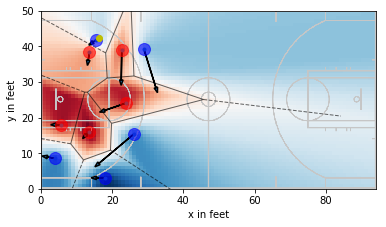

In [8]:
print_court_teams_occupation(events,0,25,voronoi_cut=True,value=True)

This quantity does therefore not only take into account the distance to a player, but also the fact that only players of the other team will dispute the control of a certain area. On the boundaries of a Voronoï cell between players of different teams the value of $\delta_d$ is per definition $\delta_d=0$. The continuous nature of $\delta_d$ allows to determine a _heat-map_ describing the occupation of the court by the players and thereby we are able to evaluate the free-space that each player has as a function of his position. Furthermore since the definition of $\delta_d$ distinguishes between the two different teams we also measure how "free" a player is.

### Looking at another way of valuing

Our way of valuing only take into account the distance between closest player of each team and the point considered. Yet, players are moving and for a fast moving player, it is more difficult to control the area behind him. Therefore, we try to cut the court taking into account players'inertia. 

To do so, we only change our way to calculate the value : for each cell, we don't calculate a distance but a relative time. Therefore, the boundaries between a defense-controlled zone and an attack-controlled zone are more precisely defined by a quantity $\delta_t$,
\begin{equation}\label{eq:deltat}
    \delta_{t}(x,y) = t_\textrm{attack}-t_\textrm{defense},
\end{equation}
where  $t_\textrm{attack}$ is the time it takes for the closest attacker (in time) to join the point $(x,y)$, and $t_\textrm{defense}$ the same time for a defender. In the unphysical case of players with zero mass, or infinite force, this $\delta_t$ should behave as $\delta_d$. However, inertia is expected to change this. Let's look at the notebook [2_Time_calculation](https://nbviewer.jupyter.org/github/AmigoCap/MecaFootCo/blob/master/2_Time_calculation.ipynb) to have details over the model introducing inertia.

In [9]:
def time_to_point(a,b,v,F=10*3.281):   
    "time to go from a to b with initial speed v, F is the force parameter in feet/s-2"
    x0,y0=a
    xf,yf=b
    X=x0-xf
    Y=y0-yf
    k4=1
    k3=0
    k2=4*(v[0]**2+v[1]**2)/F**2
    k1=8*(v[0]*X+v[1]*Y)/F**2
    k0=4*(X**2+Y**2)/F**2
    times=np.roots([k4,k3,-k2,-k1,-k0])
    for i in range(4):                      # Selection of the root real and positive
        if times[i].imag==0:
            if times[i].real>=0:
                return times[i].real
    print('error')

In [10]:
def print_court_teams_occupation_inertia(events,event_id,mom_id,voronoi_cut=False,player_info=False,n=50,p=94):
    "This function return a visualization of the court for the moment mom_id of the event event_id. If voronoi_cut=True, voronoi cutting is plotted. Then, if value=True, a heat-map giving a value to space occupation is drawn."
    if voronoi_cut:
        voronoi(events,event_id,mom_id)
    event=events[event_id]
    moment=event['moments'][mom_id]
    moment1=moment
    moment2=event['moments'][mom_id+1]
    
    # separation of ball, team1 and team2 and calculation of the speed
    mom_infos=players_ball_speed_position(moment1,moment2)
    
    ind=1
    for player in mom_infos['team2'].keys():
        x=mom_infos['team2'][player]['xy'][0]
        y=mom_infos['team2'][player]['xy'][1]
        vx=mom_infos['team2'][player]['v'][0]
        vy=mom_infos['team2'][player]['v'][1]
        plt.plot(x,y,'bo',markersize=12,alpha=0.6)
        plt.arrow(x,y,vx,vy,shape='full',lw=1.5,head_width=1)
        if player_info:
            plt.annotate(str(ind),(x,y),xytext=(3,3),textcoords='offset points')
            ind+=1
    
    for player in mom_infos['team1'].keys():
        x=mom_infos['team1'][player]['xy'][0]
        y=mom_infos['team1'][player]['xy'][1]
        vx=mom_infos['team1'][player]['v'][0]
        vy=mom_infos['team1'][player]['v'][1]
        plt.plot(x,y,'ro',markersize=12,alpha=0.6)
        plt.arrow(x,y,vx,vy,shape='full',lw=1.5,head_width=1)
        if player_info:
            plt.annotate(str(ind),(x,y),xytext=(3,3),textcoords='offset points')
            ind+=1
            
    court=np.zeros((n,p))
    for i in range(n):
        for j in range(p):
            b=np.array([j,i]) # point d'arrivée
        
            tmin_1=np.inf
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                v=mom_infos['team1'][player]['v']
                t=time_to_point(a,b,v)
                if t<tmin_1:
                    tmin_1=t
                    
            tmin_2=np.inf
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                v=mom_infos['team2'][player]['v']
                t=time_to_point(a,b,v)
                if t<tmin_2:
                    tmin_2=t
            
            court[i,j]=tmin_1-tmin_2
    im=plt.imshow(court,origin='lower', cmap='RdBu')
    #plt.colorbar(orientation='vertical')
        
    plt.plot(mom_infos['ball']['xy'][0],mom_infos['ball']['xy'][1],'yo')
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')
    field = plt.imread("Images/fullcourt.png")
    plt.imshow(field, extent=[0,94,0,50])
    #plt.savefig('Voronoi_inertie_abstract',dpi=72)
    plt.show()

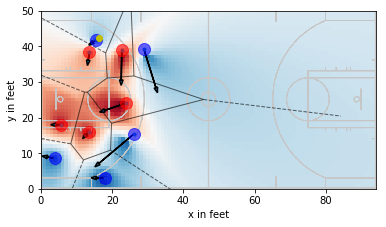

In [11]:
print_court_teams_occupation_inertia(events,0,25,voronoi_cut=True)

The boundaries between red zones and blue ones don't fit with voronoï tesselation anymore. Let's compare the valuation :

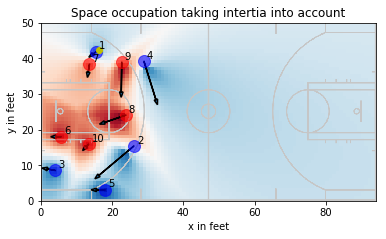

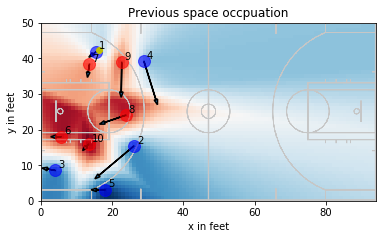

In [76]:
plt.figure(1)
plt.title('Space occupation taking intertia into account')
print_court_teams_occupation_inertia(events,0,25,player_info=True)
plt.figure(2)
plt.title('Previous space occpuation')
print_court_teams_occupation(events,0,25,voronoi_cut=False,value=True,player_info=True)

With the two figures above, we can compare classic space occupation and the one calculated taking into account inertia. As expected inertia introduce change the interpretation of occupation. Indeed, if we focus on players 4 and 8, as 4 is moving with high speed to the area behind 8 while 8 is moving in the opposite direction, 4 control the area behind 8. Visually, space occupation is more accurate with inertia. 

----
## Conclusion

In this notebook we introduced three ways to observe space occupation :
* Voronoi tesselation which is the simplest way to characterize occupation
* A team point of view of voronoï tesselation with the quantity $\delta_d$ which brings the information "how free a player is from the opponent team".
* A time-based approach in with a better visual appreciation due to the introduction of inertia.

you can find the rest of the study in the following notebooks :
* [2_time_calculation](https://nbviewer.jupyter.org/github/AmigoCap/MecaFootCo/blob/master/2_Time_calculation.ipynb) where we detail time calculation and where we explain visually the trajectories modelized by the calculation
* [3_Comparison_of_ways_to_quantify_free_space](https://nbviewer.jupyter.org/github/AmigoCap/MecaFootCo/blob/master/3_Comparison_of_ways_to_quantify_free_space.ipynb) in which the comparison of occupancy calculations is taken further and in which a new way to quantify how "free" a players is is introduced.
* [4_Free_space_and_3-points_efficiency](https://nbviewer.jupyter.org/github/AmigoCap/MecaFootCo/blob/master/4_Free_space_and_3-points_efficiency.ipynb) in which we focus on 3-points shot and the link between efficiency and free-space.